This is the demo code for spatial regression graph convolutional neural networks (SRGCNN) and its Geographically Weighted variant (SRGCNN-GW)

Please cite the following paper if it helps:

[Zhu, D., Liu, Y., Yao, X., & Fischer, M. M. (2021). Spatial regression graph convolutional neural networks: A deep learning paradigm for spatial multivariate distributions. GeoInformatica, 1-32.](https://link.springer.com/article/10.1007/s10707-021-00454-x)

SRGCNN models would require `pytorch` and `GPU` environment to implement. Spatial weights would require `PySAL` to construct (check out [here](https://pysal.org/spreg/api.htmlhttps://pysal.org/spreg/api.html)). Please refer to this `import` section for package dependency.

- Original test environment:  `python 3.9.6`, `pytorch 1.9.0`, `cudatoolkit 10.2.89`
- Baseline spatial regression models can be implemented following [the PySAL official documentation](https://pysal.org/spreg/api.htmlhttps://pysal.org/spreg/api.html), which is not included in this demo.

### 1. Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np, pandas as pd, math
import matplotlib.pyplot as plt
import geopandas as gp
import copy
import seaborn as sns
###
import torch
from torch import nn
import torch.nn.functional as F
###
from pysal.lib import weights
import pysal as ps
import esda
import spreg
###
from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from scipy.sparse import eye
from scipy import sparse
from scipy import stats
from scipy.sparse import csgraph
###
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import median_absolute_error as mae
from sklearn.neighbors import NearestNeighbors

In [3]:
# enable cuda gpu accelaration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.set_printoptions(suppress=True)

In [4]:
device

device(type='cuda', index=0)

### 2. Functionalities

In [5]:
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)            
    else:
        print ("---  There exist a folder of the same name!  ---")
def row_normalize(mx):
    '''Row-normalize sparse matrix'''
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx
def unlog(x):
    '''return x to the power of 10'''
    return pow(10,x)

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)    
    
def make_sym_matrix_boolean_sum(mx): # This will ensure the adjacent matrix to be symmetric no matter ways of definition
    return 1*np.logical_or(mx,mx.T)

def renormalized_trick_mx(mx): # This will add diagonal ones for the adjacent matrix
    return mx+np.eye(mx.shape[0])

def renormalized_trick_laplacian(mx):
    return np.eye(mx.shape[0])-csgraph.laplacian(mx,normed=True) # This will give D~^(-1/2)A~D~^(-1/2)
    
def step(model,optimizer,input_tensor,idx,target_tensor,adj): ##idx: use ids in the training set
    '''
    train with element-wise loss vector，return the mean scalar of the loss
    '''
    with torch.autograd.set_detect_anomaly(True):
        model.train()
        optimizer.zero_grad()
        output = model(input_tensor, adj)
        loss = F.mse_loss(output[idx], target_tensor[idx],reduce=False)
        loss.backward(torch.reshape(torch.ones(len(idx)).to(device),(len(idx),1)),retain_graph=False)
        optimizer.step()
        return loss.mean().item()

def evaluate(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the validation set
    '''
    Monitor the loss of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    loss = F.mse_loss(output[idx], target_tensor[idx],reduce=False)
    return loss.mean().item()

def evaluate_MAE(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the training set
    '''
    Monitor the Mean abosolute error of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    loss = F.l1_loss(output[idx], target_tensor[idx],reduce=False)
    return loss.mean().item()

def evaluate_MAPE(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the validation set
    '''
    Monitor the Mean abosolute percentage error of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    MAPE = F.l1_loss(output[idx], target_tensor[idx],reduce=False)/target_tensor[idx]
    return MAPE.mean().item() 

def return_results(model,input_tensor,idx,target_tensor,adj): ## return results as arrays
    '''
    call a model and get the predicted array and the ground truth array
    '''
    model.eval()
    output = model(input_tensor, adj)
    return output[idx].cpu().detach().numpy(),target_tensor[idx].cpu().detach().numpy()

### 3. Models

In [24]:
class GraphConvolution(nn.Module):
    """Basic graph convolution operation that incorporate both spatial lagged X 
    and spatial lagged Y (to be used in the basic SRGCNNs model)"""
    def __init__(self, f_in, f_out, use_bias=True, activation=nn.ReLU()):
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out),requires_grad=True) #
        self.bias = nn.Parameter(torch.FloatTensor(f_out),requires_grad=True) if use_bias else None
        self.initialize_weights()
    
    def initialize_weights(self):
        nn.init.constant_(self.weight,1)
        if self.use_bias: nn.init.constant_(self.bias,0)
        
    def forward(self, input, adj):
##      ---- self.method=='SRGCNN':
        support = torch.mm(input, self.weight)
        out = torch.mm(adj, support) #adj here has to be renormalized     
        
        
        if self.use_bias: out.add_(self.bias) #
        if self.activation is not None: 
            out=self.activation(out) 
        return out

class GCN(nn.Module):
    """Basic SRGCNN model"""
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.0]):
        if hidden==[]:
            super().__init__()
            self.layers=[]
            self.dropouts=[]
            self.out_layer = GraphConvolution(f_in, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
        else:
            super().__init__()
            layers = []
            for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
                layers += [GraphConvolution(f_in, f_out)]

            self.layers = nn.Sequential(*layers)
            self.dropouts = dropouts
            self.out_layer = GraphConvolution(f_out, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
    
        
    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: x = F.dropout(x, d, training=self.training, inplace=False)
             
        return self.out_layer(x, adj)   
        
class GWGraphConvolution(nn.Module):
    """Geographically weighted graph convolution operation that 
    adds locally parameterized weights to all the variables (to be used in the SRGCNNs-GW model)"""
    def __init__(self, f_in, f_out, use_bias=True, activation=nn.ReLU()):
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        #########Geographically local parameters
        self.gwr_weight = nn.Parameter(torch.FloatTensor(x_tensor.shape[0], f_in),requires_grad=True)
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out),requires_grad=True) #
        self.bias = nn.Parameter(torch.FloatTensor(f_out),requires_grad=True) if use_bias else None
        self.initialize_weights()
    
    def initialize_weights(self):
        nn.init.constant_(self.weight,1)
        nn.init.constant_(self.gwr_weight,1)
        if self.use_bias: nn.init.constant_(self.bias,0)
        
    def forward(self, input, adj):
##      ---- self.method=='SRGCNN-GW':
        gwr_support=torch.mul(input,self.gwr_weight) # use torch.mul to enable element-wise product
        support=torch.mm(adj,gwr_support) #adj here has to be renormalized     
        out=torch.mm(support,self.weight) 
        
        
        if self.use_bias: out.add_(self.bias) #
        if self.activation is not None: 
            out=self.activation(out) 
        return out

class GWGCN(nn.Module):
    """SRGCNN-GW model"""
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.0]):
        if hidden==[]:
            super().__init__()
            self.layers=[]
            self.dropouts=[]
            self.out_layer = GWGraphConvolution(f_in, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
        else:
            super().__init__()
            layers = []
            for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
                layers += [GWGraphConvolution(f_in, f_out)]

            self.layers = nn.Sequential(*layers)
            self.dropouts = dropouts
            self.out_layer = GWGraphConvolution(f_out, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
    
        
    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: x = F.dropout(x, d, training=self.training, inplace=False)
             
        return self.out_layer(x, adj)   



### 4. Case Data 
(For this open repository, we only show the airbnb case described in the Appendix section of paper)

In [7]:
db = gp.read_file('./airbnb/regression_db.geojson')
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

In [8]:
# the basic independent variables used for regression
variable_names = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds'
]
# the appended independent variables used for regression (may be used for feature engineering)
variable_names_append = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds', 
    'rt_Private_room', 
    'rt_Shared_room',
    'pg_Condominium', 
    'pg_House', 
    'pg_Other', 
    'pg_Townhouse',
    'coastal'
]

<AxesSubplot:>

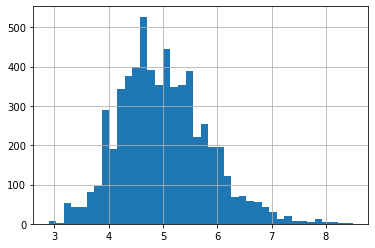

In [9]:
db.log_price.hist(bins=40)

<AxesSubplot:>

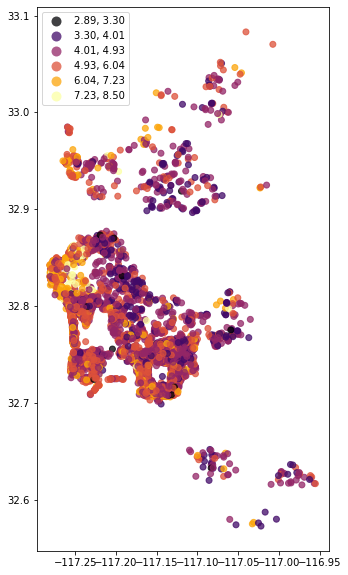

In [10]:
f,ax=plt.subplots(1,1,figsize=(10,10))
db.plot(column='log_price',cmap='inferno',scheme='percentiles',alpha=0.75,legend=True,ax=ax)

### 4. Settings

Spatial weights, variables and hyperparameters

In [11]:
knn=weights.KNN.from_dataframe(db,geom_col='geometry',k=20)

A_20nn_sym=make_sym_matrix_boolean_sum(knn.full()[0])
A_tilde_20nn_sym=renormalized_trick_mx(A_20nn_sym)
Laplacian_knn=renormalized_trick_laplacian(A_tilde_20nn_sym)
# check_symmetric(Laplacian_knn)

adj=torch.FloatTensor(Laplacian_knn).to(device)

In [20]:
### The observations for data regression
x_tensor=torch.FloatTensor(db[variable_names].values.tolist()).to(device)
x_append_tensor=torch.FloatTensor(db[variable_names_append].values.tolist()).to(device)
y_tensor=torch.FloatTensor(db[['log_price']].values.tolist()).to(device)
idx_all=torch.LongTensor(db.index.values).to(device)

In [21]:
### Params settings for the model on limited Xs
n_labels = 1 # #output feature dimension:log_price
n_features = len(variable_names)# #input feature dimensional vector
epochs = 18000 # #max training epoch
lr = 3e-2 ##learning rate

### 5. Train the Model
For demo usage, we here only show a simple case for SRGCNN-GW without further fine tuning; try `model=GCN(...)` for the basic SRGCNN model; try replace `x_tensor` with `x_append_tensor` and `n_features` for another scenario of independent variables; try change the array of hidden layers and corresponding dropouts in `GWGCN()` to test different model architectures; try more training epochs and smaller learning rate to obtain better fitting accuracy.

In [25]:
model=GWGCN(n_features,n_labels,hidden=[8*n_features],dropouts=[0.5]).to(device)
optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr,weight_decay=lr)
lowest_mean_global_MAPE=99999.0
min_global_MAPE_epoch=-1
train_loss_arr=[]
mape_arr=[]
for i in range(0,epochs):
    train_loss=step(model,optimizer,x_tensor,idx_all,y_tensor,adj) ## For demo, train with all ids "idx_all"
    train_loss_arr.append(train_loss)
    global_MAPE=evaluate_MAPE(model,x_tensor,idx_all,y_tensor,adj) ## For demo, evaluate with again all ids "idx_all"
    mape_arr.append(global_MAPE*100)

    if global_MAPE<lowest_mean_global_MAPE:
        lowest_mean_global_MAPE=global_MAPE
        output,target=return_results(model,x_tensor,idx_all,y_tensor,adj)##############
        min_global_MAPE_epoch=i

    if i%1000==0 or i==epochs-1:
        print("epoch:"+str(i)+"--train_loss:"+str(train_loss))
        print(" --global_MAPE:"+'{:.4f}%'.format(global_MAPE*100))

epoch:0--train_loss:94855.3828125
 --global_MAPE:5265.7547%
epoch:1000--train_loss:0.585659384727478
 --global_MAPE:11.6721%
epoch:2000--train_loss:0.5205478668212891
 --global_MAPE:10.9542%
epoch:3000--train_loss:0.4903014004230499
 --global_MAPE:10.5663%
epoch:4000--train_loss:0.4542057514190674
 --global_MAPE:10.1536%
epoch:5000--train_loss:0.42000576853752136
 --global_MAPE:9.7323%
epoch:6000--train_loss:0.3847609758377075
 --global_MAPE:9.2447%
epoch:7000--train_loss:0.34354859590530396
 --global_MAPE:8.7226%
epoch:8000--train_loss:0.3069729804992676
 --global_MAPE:8.1782%
epoch:9000--train_loss:0.2627423107624054
 --global_MAPE:7.4274%
epoch:10000--train_loss:0.22148336470127106
 --global_MAPE:6.5812%
epoch:11000--train_loss:0.19859212636947632
 --global_MAPE:6.0374%
epoch:12000--train_loss:0.1869257688522339
 --global_MAPE:5.9681%
epoch:13000--train_loss:0.18446801602840424
 --global_MAPE:5.9986%
epoch:14000--train_loss:0.1914893239736557
 --global_MAPE:6.1435%
epoch:15000--trai

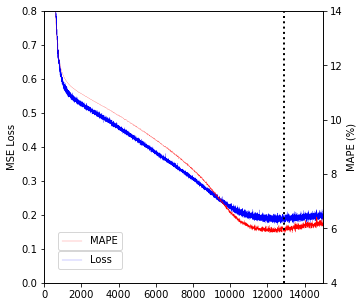

In [26]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(train_loss_arr,lw=0.2,color='b',alpha=1,label='Loss  ')
ax.set_xlim([0,15000])
ax.set_ylim([0,0.8])
ax2=ax.twinx()
ax2.plot(mape_arr,lw=0.2,color='r',alpha=1,label='MAPE')
ax2.set_ylim([4,14])
ax2.legend(loc=(0.05,0.12))
ax.legend(loc=(0.05,0.05))
ax.set_ylabel('MSE Loss')
ax2.set_ylabel('MAPE (%)')
plt.axvline(min_global_MAPE_epoch, linestyle="dotted", linewidth=2, color='black')

### 6. Output Statistics

The best results are recorded in the output array

In [27]:
mape=(mae(output,target)/target).mean()
mape # mean absolute percentage error between predicted y and the real y

0.04807747

Model goodness of fit

In [28]:
SSE=np.sum((target-output)**2)
SST=np.sum((db[['log_price']].values-db[['log_price']].values.mean())**2)

Rsq=1-SSE/SST
Rsq # R-square of model fit

0.788772533217433

Moran's I of the model errors

In [29]:
Ierror = esda.moran.Moran(output-target, knn)
print('Errors  moransI: '+str(Ierror.I)+'  Z_I: '+str(Ierror.z_norm)+' p-value: '+str(Ierror.p_sim))

Errors  moransI: 0.04792676981490909  Z_I: 12.545961523211115 p-value: 0.001


### 7. Visualization

Text(0.5, 1.0, 'error')

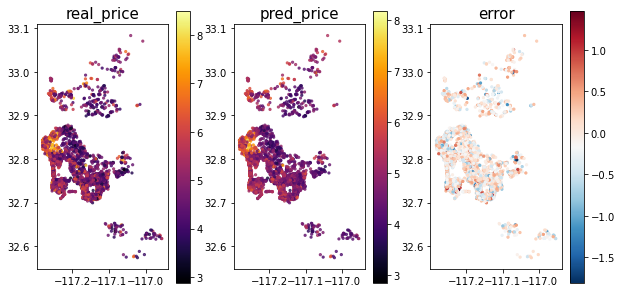

In [30]:
dbplot=db.loc[:,['log_price','geometry']].copy()
dbplot['pred']=output
dbplot['error']=output-db[['log_price']].values

f,ax=plt.subplots(1,3,figsize=(10,5))

dbplot.plot(column='log_price',cmap='inferno',s=5,alpha=0.75,legend=True,ax=ax[0])
dbplot.plot(column='pred',cmap='inferno',s=5,alpha=0.75,legend=True,ax=ax[1])
dbplot.plot(column='error',cmap='RdBu_r',s=5,alpha=1,legend=True,ax=ax[2])
ax[0].set_title('real_price',fontsize=15)
ax[1].set_title('pred_price',fontsize=15)
ax[2].set_title('error',fontsize=15)

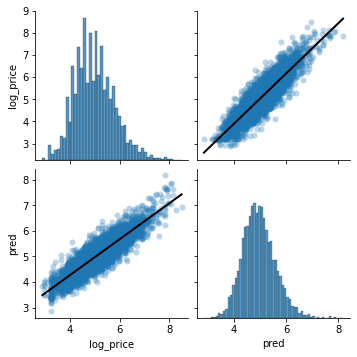

In [31]:
sns.pairplot(dbplot.drop('error',axis=1),diag_kind="hist",\
             kind='reg',plot_kws={'line_kws':{'color':'black','lw':2}, 'scatter_kws': {'linewidth':0,'alpha': 0.3}})